# Personal Information
Name: **Xiaoyu Wu**

StudentID: **12538922**

Email: [**xiaoyu.wu@student.auc.nl**](youremail@student.uva.nl)

Submitted on: **19.03.2023**

Github repo: **https://github.com/XiaoYu-Wu12138/WW2-Comics**

# Data Context

The dataset for this project has been provided by NIOD and includes comics and photographs from the Second World War (WW2) and the immediate post-war period. The dataset provides a unique glimpse into the daily life, popular culture, and propaganda of the time. The comics portion of the dataset contains over 26,000 panels and mainly covers historical and war genres. Each page is composed of several panels that contain multiple frames and characters with accompanying speech bubbles. However, no annotations have been observed in the dataset. In addition, it is worth noting that the panels in the comics portion of the dataset consist of both color and grayscale images. This adds an extra level of complexity to the data, as color images require additional preprocessing steps and may contain more information than grayscale images.

Extra datasets: 
Flickr30K Entities and COCO (Common Objects in Context) are two popular and widely used datasets/benchmarks in the field of computer vision and natural language processing. The Flickr30K Entities dataset consists of 31,000 images, each of which is annotated with 5 sentences describing the image content. The annotations cover a wide range of topics, including objects, actions, and relationships, and provide a rich source of multimodal data for analyzing the relationship between visual and linguistic information. On the other hand, COCO is a large-scale dataset that contains over 330,000 images of 80 different object categories. The images are annotated with bounding boxes and segmentation masks for each object, as well as captions describing the image content. 

# Data Description
The flowchart below illustrates the process for conducting exploratory data analysis. The subsequent sections will provide a detailed explanation of each component.


We will examine characteristics such as the dimensions of the image/panel, the panel count per page (by extracting frames), the types of entities present in the panel (using object detection), and also perform text analysis utilizing OCR.

In [2]:
# Import all necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.image as mpimg
from collections import Counter

### Data Loading

The dataset comprises of both comics and photographs. Initially, we **manually exclude the photographs** from the dataset. The remaining comics are stored in various folders and formats, primarily in .cbr format. To proceed with the data processing, we need to **convert the .cbr format to .jpg** format. After the conversion, we can load the processed data from a specific folder. Since there will be several instances of format conversion and merging, the following code will focus on **one** specific folder. 

### Dimension and Color: 
The dataset contains both color and grayscale images, with varying dimensions and resolutions. To ensure that the text in the images is clear and easily extractable, we will keep the dimensions and resolution high. Additionally, since most of the images are grayscale, we will convert all images to grayscale format.

In [3]:
# Set the desired dimensions for the images
width = 1600
height = 2000

# Create the input and output directories
dir_path = 'Commando 0124'
output_dir = 'resize'

# Create an empty list to store the image data
images = []

# Loop through all images in the input directory
for filename in os.listdir(dir_path):
    # Load the image
    img = Image.open(os.path.join(dir_path, filename))
    
    # Resize the image to the desired dimensions
    img = img.resize((width, height))
    # Convert the image to grayscale
    img = img.convert('L')
    # Convert the image to a numpy array
    img_data = np.array(img)
    # Append the image data to the list of images
    images.append(img_data)
    
    # Save the resized image to the output directory
    img.save(os.path.join(output_dir, filename))
    
# Convert the list of images to a numpy array
images = np.array(images)

In [4]:
# Print the dimensions of the array
print('Image data shape:', images.shape)

Image data shape: (64, 2000, 1600)


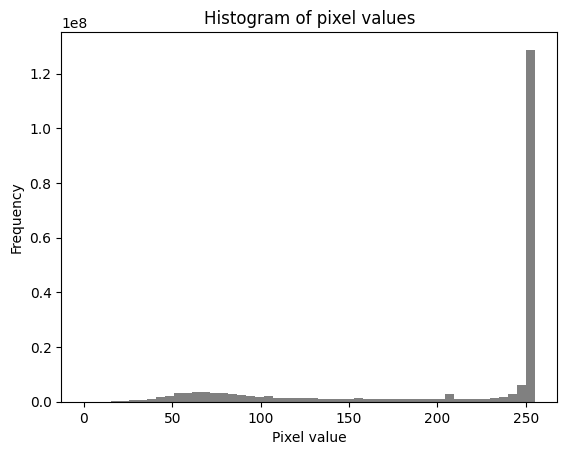

Mean pixel value: 208.75787971191406
Standard deviation of pixel values: 73.40881028592585
Minimum pixel value: 0
Maximum pixel value: 255


In [5]:
# Plot a histogram of pixel values
plt.hist(images.flatten(), bins=50, color='gray')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.title('Histogram of pixel values')
plt.show()

# Calculate some summary statistics
print('Mean pixel value:', np.mean(images))
print('Standard deviation of pixel values:', np.std(images))
print('Minimum pixel value:', np.min(images))
print('Maximum pixel value:', np.max(images))

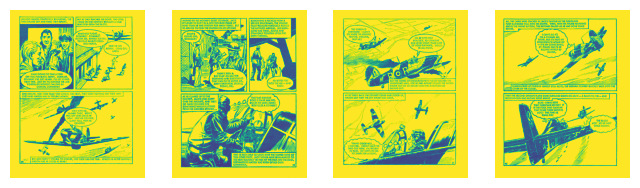

In [6]:
# Plot some sample images
n = 4  # Number of images to plot
plt.figure(figsize=(8,8))
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

### Frame detection: 

Each comics page consists of multiple frames, so we aim to determine the typical number of frames found in each page in the dataset. 
Detecting the frames within each page is also essential to partition the dataset into frame-level and page-level data for future analysis.


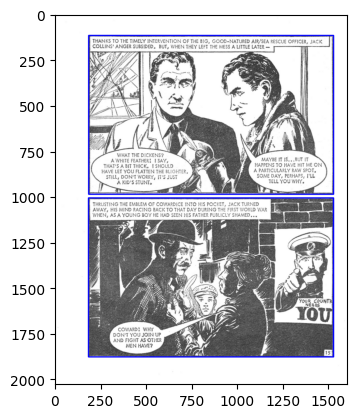

3

In [42]:
# Load an example of  comic image
img = cv2.imread('Commando 0124/p15.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Canny edge detection
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Find contours in the edges image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Loop over the contours and filter out the ones that are not frames
frames = set()
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 700 and h > 800: # adjust the minimum width and height to filter out small contours
        aspect_ratio = float(w)/h
        if aspect_ratio > 0.3 and aspect_ratio < 3.0: # adjust the aspect ratio range to filter out non-frame contours
            frame=(x, y, w, h)
            if frame not in frames:
                frames.add(frame)

# Draw rectangles on the frames
for x, y, w, h in frames:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 5)

# Display the image with the identified frames
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
len(frames)

In [16]:
# Frame separation 

# Crop the image to the bounding boxes to extract the frames
for i, frame in enumerate(frames):
    x, y, w, h = frame
    frame_img = img[y:y+h, x:x+w]
    cv2.imwrite(f'frame_{i}.jpg', frame_img)

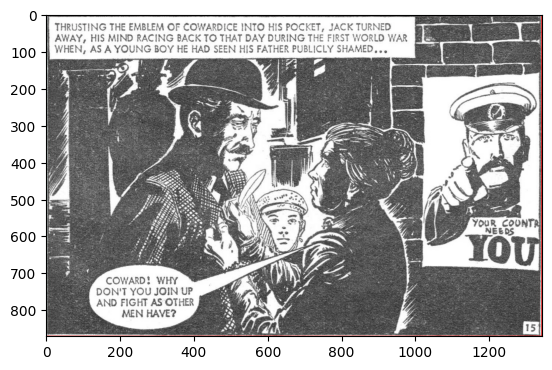

In [17]:
# Load and display the first frame
img = mpimg.imread('frame_2.jpg')
plt.imshow(img)
plt.show()

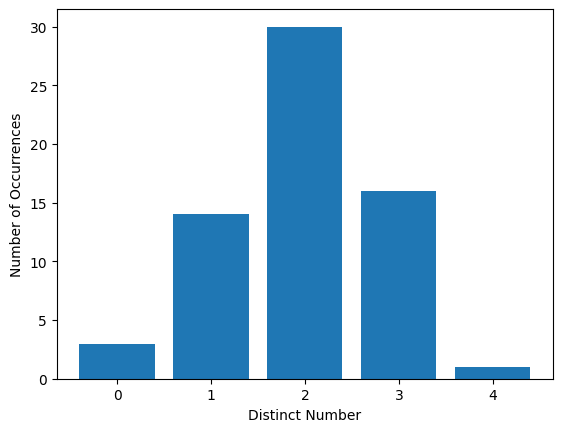

In [21]:
# plot graph 
folder_path = output_dir

counts = []

for filename in os.listdir(folder_path):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        # Load the image
        img = cv2.imread(os.path.join(folder_path, filename))

        # Convert the image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Apply Canny edge detection
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        
        # Find contours in the edges image
        contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Loop over the contours and filter out the ones that are not frames
        frames = set()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            if w > 700 and h > 800:
                aspect_ratio = float(w)/h
                if aspect_ratio > 0.3 and aspect_ratio < 3.0: 
                    frame = (x, y, w, h)
                    if frame not in frames:
                        frames.add(frame)

        #Store the number of frames in the image
        counts.append(len(frames))


# Count the number of occurrences of each distinct number
count_dict = dict(Counter(counts))

# Create a bar chart with the distinct numbers on the x-axis and the number of occurrences on the y-axis
plt.bar(count_dict.keys(), count_dict.values())

# Add axis labels
plt.xlabel('Distinct Number')
plt.ylabel('Number of Occurrences')

# Show the plot
plt.show()

In [22]:
count_dict

{2: 30, 1: 14, 3: 16, 0: 3, 4: 1}

### Object detection: 

The purpose of this detection analysis is to gain a general understanding of the types of entities present in the dataset.

The hypothesis is that comics primarily feature characters, so it is expected that the entities will be mostly singular. However, this presents a challenge in linking text to visuals since character names are often not explicitly mentioned in speech bubbles or text within the panels. Keeping a record of this information will be useful in evaluating the performance of the proposed method.


In [23]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00


In [24]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00


In [67]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

image = Image.open('Commando 0124/p05.jpg').convert('RGB')

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.8
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )


Detected person with confidence 0.969 at location [340.24, 347.09, 761.66, 894.37]
Detected person with confidence 0.996 at location [821.51, 408.67, 1249.22, 969.92]


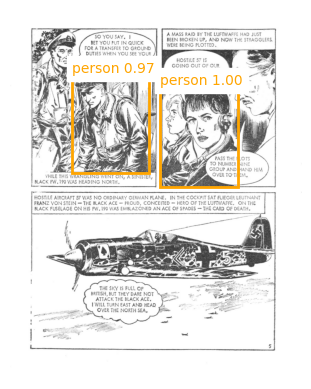

In [68]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Plot the image
plt.imshow(image)
plt.axis('off')

# Retrieve the bounding boxes and labels
scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

# Plot the bounding boxes
for score, label, box in zip(scores, labels, boxes):
    box = [round(i, 2) for i in box]
    label = model.config.id2label[label]
    rect = Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], fill=False, color='orange', linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(box[0], box[1], f"{label} {score:.2f}", color='orange', fontsize=10, backgroundcolor='w')

# Show the image with bounding boxes
plt.show()


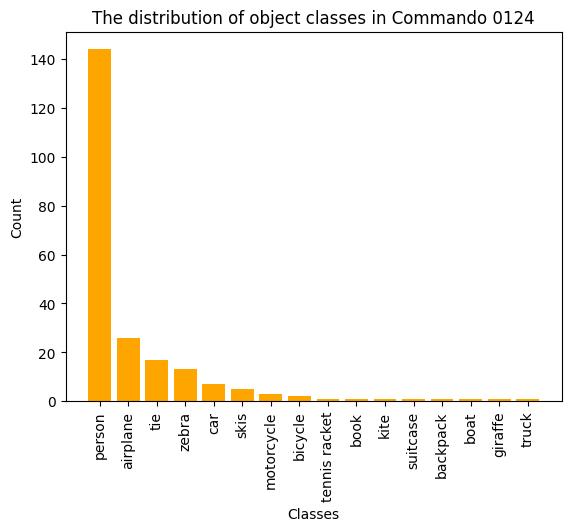

In [70]:
import os
import matplotlib.pyplot as plt

entity_counts = {}

# Specify the path to the image folder
image_folder = "resize"

# Loop through the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)
        image = Image.open(image_path).convert('RGB')

        # Process the image and obtain the object detection results
        inputs = processor(images=image, return_tensors="pt")
        outputs = model(**inputs)
        target_sizes = torch.tensor([image.size[::-1]])
        results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.8)[0]

        # Count the entity types in the results
        for label in results["labels"]:
            entity_label = model.config.id2label[label.item()]
            entity_counts[entity_label] = entity_counts.get(entity_label, 0) + 1

# Extract the entity labels and their corresponding counts
labels = list(entity_counts.keys())
counts = list(entity_counts.values())

# Sort the counts and labels in descending order
sorted_indices = sorted(range(len(counts)), key=lambda k: counts[k], reverse=True)
labels = [labels[i] for i in sorted_indices]
counts = [counts[i] for i in sorted_indices]

# Plot the bar chart with orange color
plt.bar(labels, counts, color='orange')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('The distribution of object classes in Commando 0124')
plt.xticks(rotation=90)
plt.show()



The "person" class dominates the other classifications, indicating that the comics primarily focuses on depicting characters rather than other objects. 

Furthermore, since our dataset pertains mainly to World War II, the class that defines types of vehicles/transportation is also substantial.

As part of our thesis project, we then aim to update or replace the existing classifications with words/phrases that appear in the text to better represent the classified segment.


### OCR & Nouns Extraction:

After retrieving the texts from the comics, we could study about the words:

Text and Noun Extraction: Use OCR to extract texts from comics and then use NLTK to extract nouns from the texts.

Data Cleaning: This involves removing special characters, punctuation, stop words, and any other irrelevant information from the text.

Frequency Analysis: We perform a frequency analysis to determine the most common words or phrases in the text. 

Visualizations: Visualization techniques, such as word clouds, bar charts, and histograms, can be used to display the results of the frequency analysis.


In [ ]:
# import paddle
%pip install paddlepaddle==2.4.1 -i https://pypi.tuna.tsinghua.edu.cn/simple
import paddle
paddle.utils.run_check()
%pip install "paddleocr>=2.0.1" 
%pip install nltk

In [ ]:
from paddleocr import PaddleOCR
import os

ocr = PaddleOCR(use_angle_cls=True, lang="en")  # need to run only once to download and load model into memory

yourpath = 'Commando 0124'
all_texts = []

# retrieve all images from the directory 
for root, dirs, files in os.walk(yourpath, topdown=False):
    for name in files:
        img_path = os.path.join(root, name)
        # for single image 
        result = ocr.ocr(img_path, cls=True)
        new_result=result[0]
        texts = [line[1][0] for line in new_result]
        all_texts.extend(texts)


In [73]:
# example texts extracted 
all_texts[:5]

['LEAVING MASON COMPLETELY BEWILDERED,THE',
 'BUTAS THEY REACHED THE DOOR,THE COOL',
 'TWO STALKED OFF AND MADE THEIR REPORT.',
 'VOICE ON THE TANNOY BROUGHT A WILD',
 'REACTION FROM THE PILOTS.']

In [77]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [78]:
# extract nouns from texts 
s = ''.join(all_texts)
s = s.lower()
lines = s
# function to test if something is a noun
is_noun = lambda pos: pos[:2] == 'NN'
# tokenization 
tokenized = nltk.word_tokenize(lines)
nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 

print(nouns[:10])

['mason', 'door', 'cooltwo', 'report.voice', 'tannoy', 'wildreaction', 'pilots.readiness', 'flight', 'vector', 'angels']


In [79]:
from nltk.corpus import stopwords
import re

# Download necessary data
nltk.download('stopwords')

# Define preprocessing function
def preprocess_words(word_list):
    # Convert all text to lowercase
    word_list = [word.lower() for word in word_list]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    word_list = [word for word in word_list if word not in stop_words]
    
    # Remove punctuation
    word_list = [re.sub(r'[^\w\s]', '', word) for word in word_list]
    
    return word_list


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [80]:
print(preprocess_words(nouns)[:10])

['mason', 'door', 'cooltwo', 'reportvoice', 'tannoy', 'wildreaction', 'pilotsreadiness', 'flight', 'vector', 'angels']


In [81]:
import collections
# count the frequency of each word
word_counts = collections.Counter(nouns)

# sort the results in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)

In [82]:
import matplotlib.pyplot as plt
# extract the words and counts into separate lists
words = [item[0] for item in sorted_word_counts]
counts = [item[1] for item in sorted_word_counts]

# create a bar chart of the word frequencies
# plt.bar(words, counts)

In [83]:
def plot_most_word_frequency(words):
    # count the frequency of each word
    word_counts = collections.Counter(words)
    
    # get the most common words and their counts
    most_common = word_counts.most_common(30)
    labels, values = zip(*most_common)
    
    # plot the bar chart
    plt.bar(labels, values)
    plt.title('Word Frequency')
    plt.xlabel('Words')
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.show()

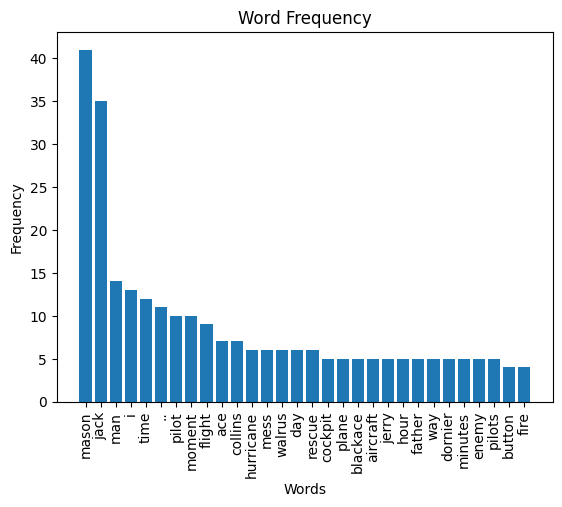

In [84]:
plot_most_word_frequency(nouns)

To our surprise, the most frequently occurring words in this folder of comics images are "Mason" and "Jack," which may be the names of two primary characters in the comics. In this case, the characters' names are mentioned frequently enough in the comics. Our next step is to match the names with the corresponding characters in the comics.

However, there are also several nouns in the frequency list that require further cleaning. Words such as "way," "time," and "day" are less informative and do not belong to any object classification.

Moreover, since the frequency analysis may not capture infrequent but specific and useful words, we'll explore alternative methods (i.e NER) to ensure that we don't overlook important information during our analysis.